# <center>Practical 08: Introduction to Reinforcement Learning</center>

<p style="color:#0000FF";> <b>Lets first make sure that all the required dependencies are installed</b></p> 

### With pip (in your local machine)
1. Open Anaconda prompt
2. Type ``pip install gym``
3. If pip is missing, type ``conda install pip``

### In AWS
1. Add and execute the following line at the beginning of your notebook
```python 
import sys
!{sys.executable} -m pip install gym```

### Let us first import all the required dependencies

In [1]:
%matplotlib notebook


import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from gym_simple_gridworlds.envs.grid_env import GridEnv
from gym_simple_gridworlds.envs.grid_2dplot import *
from gym_simple_gridworlds.helper import *

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. Define an MDP (Grid World)

Recall the grid in which our robot lives

<img src="Support/images/GridWorldExample.png" width="400" height="400" align="center">

- The states $s \in \mathcal{S}$ correspond to locations in the grid. Each location has also a cell index associated to it, e.g., cell index 4 is associated to location (1,0)
- The robot can move up, down, left, or right. Actions correpond to unit increments or decrements in the specified direction.
    - Up : (1,0)
    - Down: (-1,0)
    - Left: (0,-1)
    - Right: (0, 1)
- Each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3. No actions are available at a terminal state

We have defined the class ``GridEnv`` to represent our Grid World MDP. **Take a look at the attributes of this class by placing the cursor somewhere on the class' name and hit SHIFT+TAB. If there's a + button at the top of the popup tooltip, this means the documentation spans a few lines, click it to show the full docstring, then scroll up.**

Note: In this implementation, for simplicity, the reward and state transition functions are indexed by the cell and action indexes

In [3]:
# Create a Grid World instance
grid_world = GridEnv()

Let's take a look at the current state transition function. By default, our state transition function is deterministic. For example, at the state (1, 2), i.e., 5th cell, if the agent moves up, it will transition with 100% probability to the state (2, 2), i.e, the 9th cell

In [4]:
print(grid_world.state_transitions[5,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


## 1.1 Deterministic vs Stochastic State Transitions

Let's see how the path of an agent moving on our grid world changes with the definition of the state transition function.

We start defining a deterministic policy matrix that indicates which action is executed by the agent at a given state. No actions are available at terminal states.

In [5]:
policy_matrix = np.array([[3,      3,  3,  -1],
                          [0, np.NaN,  0,  -1],
                          [0,      1,  1,   1]])

If we apply this policy, in a grid world with a deterministic transition function, the agent can reach the goal state (green rectangle) with the shortest path.

<IPython.core.display.Javascript object>


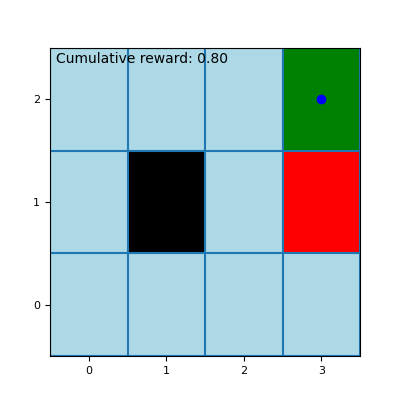

In [6]:
cur_state = grid_world.cur_state
s_x, s_y = get_state_to_plot(grid_world)

# We can visualize our grid world using the render() function
fig, ax = grid_world.render()
agent, = ax.plot([], [], 'o', color='b', linewidth=6)
reward_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

done = False
cumulative_reward = 0
path_to_plot = []

while not done:
    cur_state, cur_reward, done, _ = grid_world.step(int(policy_matrix[cur_state[0], cur_state[1]]))
    n_x, n_y = get_state_to_plot(grid_world)
    cumulative_reward += cur_reward
    path_to_plot.append([cumulative_reward, n_x, n_y])

def init():
    agent.set_data(s_x + 0.5, s_y + 0.5)
    reward_text.set_text('')
    return agent, reward_text

def animate(i):
    if i < len(path_to_plot):
        r, n_x, n_y = path_to_plot[i]
        agent.set_data(n_x + 0.5, n_y + 0.5)
        reward_text.set_text('Cumulative reward: %.2f' % r)
    return agent, reward_text

ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=500, init_func=init,
                              repeat=False)

We can define a stochastic transition matrix by setting the noise attribute to a non-zero value. We will use 0.5.

With this new transition function, at the state (1,2), i.e., 5th cell, if the agent chooses to move up, it will end up at:
- state (2, 2), i.e, the 9th cell with $50\%$ probability,
- state (1, 2), i.e, the 5th cell with $25\%$ probability, or
- state (1, 3), i.e, the 6th cell with $25\%$ probability


In [7]:
# Create a new grid world environment and set noise=0.5
grid_world = GridEnv(noise=0.5)

# Let's see how the transition matrix changes
print(grid_world.state_transitions[5,0])

[0.   0.   0.   0.   0.   0.25 0.25 0.   0.   0.5  0.  ]


**Flux Question**: What happens to the cumulative reward when we define a stochastic state transition function (``noise=0.5``)? Execute the code below and see how the value displayed at the top-left corner changes

<IPython.core.display.Javascript object>


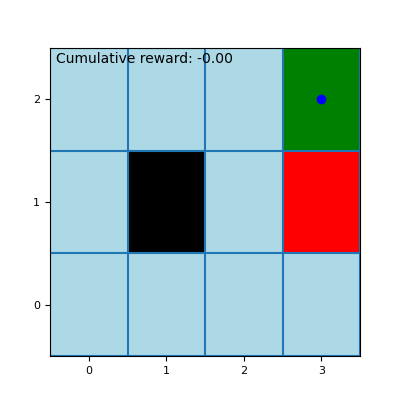

In [8]:
grid_world = GridEnv(noise=0.5)
cur_state = grid_world.cur_state
s_x, s_y = get_state_to_plot(grid_world)

# We can visualize our grid world using the render() function
fig, ax = grid_world.render()
agent, = ax.plot([], [], 'o', color='b', linewidth=6)
reward_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

done = False
cumulative_reward = 0
path_to_plot = []

while not done:
    cur_state, cur_reward, done, _ = grid_world.step(int(policy_matrix[cur_state[0], cur_state[1]]))
    n_x, n_y = get_state_to_plot(grid_world)
    cumulative_reward += cur_reward
    path_to_plot.append([cumulative_reward, n_x, n_y])

def init():
    agent.set_data(s_x + 0.5, s_y + 0.5)
    reward_text.set_text('')
    return agent, reward_text

def animate(i):
    if i < len(path_to_plot):
        r, n_x, n_y = path_to_plot[i]
        agent.set_data(n_x + 0.5, n_y + 0.5)
        reward_text.set_text('Cumulative reward: %.2f' % r)
    return agent, reward_text

ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=500, init_func=init,
                              repeat=False)

# 2. Iterative Policy Evaluation

Recall the definition of the iterative policy evaluation algorithm

<img src="Support/images/IterativePolicyEvaluation.png" width="600" height="600" align="center">

Let's now compute the value function of the following policy $\pi$

<img src="Support/images/PolicyEvaluation.png" width="300" height="300" align="center">

We consider a grid world environment with the following attributes:
- Discount factor $\gamma = 0.9$ (class attribute ``gamma=0.9``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- Rewards are only obtained at terminal states (class attribute ``living_reward=0.0``)

We have defined the helper function ``encode_policy()`` to encode the policy $\pi$ shown in the image above. The return variable ``policy_pi`` is a dictionary of dictionaries, where each element corresponds to the probability of selecting an action $a$ at a given state $s$

Keep in mind that each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3.

In [9]:
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=0.0)
policy_pi = encode_policy(grid_world)

# This is the probability of selection the action (Up) at cell 0 (state (0,0) in the grid)
print(policy_pi[0][0])

1.0


Given the policy $\pi$, let's know compute its state-value function using iterative policy evaluation.

**TODO**: 
- Complete the computation of the discounted value of successor states $\sum_{s' \in \mathcal{S}}\mathcal{T}(s,a,s')v(s')$
- Keep in mind that the attribute ``grid_env.state_transitions`` corresponds to the state transition function

<IPython.core.display.Javascript object>


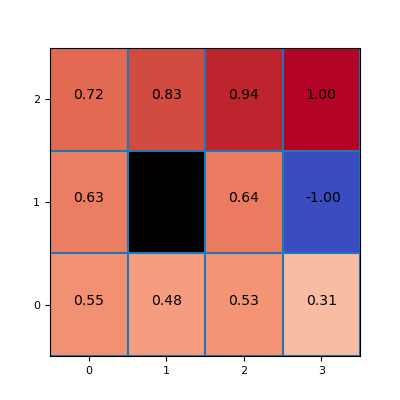

In [10]:
def policy_evaluation(grid_env, policy, plot=False, threshold=0.00001):
    
    """
    This function computes the value function for a policy pi in a given environment grid_env.
    
    :param grid_env (GridEnv): MDP environment
    :param policy (dict - stochastic form): Policy being evaluated
    :return: (dict) State-values for all non-terminal states
    """
        
    # Obtain list of all states in environment
    v = {s: 0.0 for s in grid_env.get_states()}
    theta = threshold
    delta = 1000

    while delta > theta:
        delta = 0.0
        # For all states
        for s in v.keys():

            old_v = v[s]
            new_v = 0

            # For all actions
            for a, probability_a in policy[s].items():
                discounted_value = 0

                # For all states that are reachable from s with action a
                for s_next in grid_env.get_states():
                    # TODO: Complete the computation of the discounted value of successor states
                    discounted_value += grid_env.state_transitions[s, a, s_next] * v[s_next]
                    pass
                    
                # Compute new value for state s
                new_v += probability_a*(grid_env.rewards[s, a] + grid_env.gamma*discounted_value)

            v[s] = new_v
            delta = max(delta, np.abs(old_v - new_v))

    if plot:
        plot_value_function(grid_env, v)
        
    return v
        
        
# Call the policy evalution function
v = policy_evaluation(grid_world, policy_pi, plot=True)

**Flux Question**: What is the value of state (2,0)? Keep in mind that coordinates are given in (row, col) format

# 3. Policy Iteration

Recall the definition of the policy iteration algorithm

<img src="Support/images/PolicyIteration.png" width="600" height="600" align="center">

Starting with a random policy, let's find the optimal policy for a grid world environment with attributes:

We consider a grid world environment with the following attributes:
- Discount factor $\gamma = 0.9$ (class attribute ``gamma=0.9``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- Rewards are only obtained at terminal states (class attribute ``living_reward=0.0``)

We will first define the helper methods:
- ``one_step_lookahead(grid_env, state, value_function)``, this method computes the action-value function for a state $s$ given the state-value function $v$. This corresponds to $\mathcal{R}(s,a) + \gamma\sum_{s' \in \mathcal{S}}\mathcal{T}(s,a,s')v_\pi(s')\, \forall \, a \in \mathcal{A}$
- ``update_policy(grid_world, policy, value_function)``, this method updates the current policy $\pi$ given the state-value function $v$ by taking the action $a$ with the highest action-value. action-values are obtained using the function
- ``define_random_policy(grid_env)`` in script ``helper.py``, this method generates a random policy for environment ``grid_env``

In [11]:
def one_step_lookahead(grid_env, state, value_function):
    """
     Compute the action-value function for a state $s$ given the state-value function $v$.
     
     :param grid_env (GridEnv): MDP environment
     :param state (int): state for which we are looking one action ahead
     :param value_function (dict): state-value function associated to a given policy py
     
     :return: (np.array) Action-value functions of actions available at state s
    """
    action_values = []
    
    for action in grid_env.get_actions():
        discounted_value = 0
        for s_next in grid_env.get_states():
             discounted_value += grid_env.state_transitions[state, action, s_next] * value_function[s_next]
        
        q_a = grid_env.rewards[state, action] + grid_env.gamma * discounted_value
        action_values.append(q_a)
    
    return np.array(action_values)

In [12]:
def update_policy(grid_env, cur_policy, value_function):
    """
     Update a given policy based on a given value_function
     
     :param grid_env (GridEnv): MDP environment
     :param cur_policy (matrix form): Policy to update
     :param value_function: state-value function associated to a policy cur_policy
     
     :return: (dict) Updated policy
    """
    
    states = grid_env.get_states(exclude_terminal=True)
    
    for s in states:
        action_values = one_step_lookahead(grid_env, s, value_function)
        
        # Find (row, col) coordinates of cell with index s
        row, col = np.argwhere(grid_env.grid == s)[0]
        
        cur_policy[row, col] = np.argmax(action_values)
        
    return cur_policy

Let's now define the policy iteration core algorithm.

**TODO**: Complete the main steps of the policy iteration algoritm.
- Use ``policy_evaluation(.)`` to compute the state-value function of a given policy
- Use ``update_policy(.)`` to obtain an updated policy

In [13]:
def policy_iteration(grid_env, policy, plot=False):
    """
    This function iteratively updates a given policy pi for a given environment grid_env until convergence to optimal policy
    
    :param grid_env (GridEnv): MDP environment
    :param policy (matrix from): Deteministic policy being updated
    :return: (dict) State-values for all non-terminal states
    """
    prev_policy = np.zeros(policy.shape)
    
    while not np.all(np.equal(prev_policy, policy)):
        
        # Encode policy. This policy representation is needed for policy evaluation
        encoded_policy = encode_policy(grid_env, policy)
        # Set prev_policy to current policy
        prev_policy = policy.copy()
        
        #TODO: Complete the remaining steps
        # 1. Evaluate the given policy (policy evaluation expects the enconded policy)
        value_function = policy_evaluation(grid_env, encoded_policy)
        # 2. Update policy using helper function update_policy
        policy = update_policy(grid_env, policy, value_function)

        
    if plot:
        plot_policy(grid_env, policy)
    
    return policy


<IPython.core.display.Javascript object>


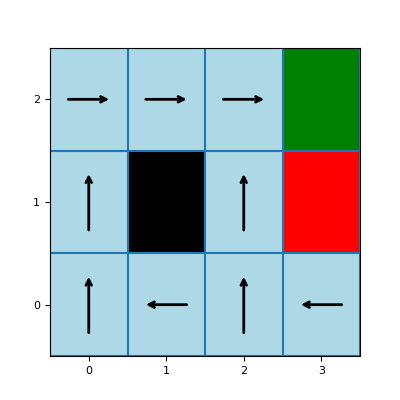

In [14]:
# Create a grid world mdp
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=0.0)

# Generate an initial random policy
initial_policy = define_random_policy(grid_world)

# Compute optimal policy using policy iteration
optimal_policy = policy_iteration(grid_world, initial_policy, plot=True)

**Flux Question**: What is the optimal sequence of actions to go from state (0,1) to state (2,3)? Keep in mind that coordinates are given in (row, col) format

# Coding Exercise (6 pts) - Implement Value Iteration

You are tasked with implementing the value iteration algorithm shown below:
    
<img src="Support/images/ValueIteration.png" width="500" height="500" align="center">

Please keep in mind:
- **TODO 1**: Use the helper method ``one_step_lookahead(.)`` to update of your current $v(s)$ according to:
$v(s) \leftarrow \max_{a \in \mathcal{A}} \Bigl(\mathcal{R}(s,a) + \gamma\sum_{s' \in \mathcal{S}}\mathcal{T}(s,a,s')v(s')\Bigr)$
- **TODo 2**: Use the helper method ``update_policy(.)`` to obtain the deterministic optimal policy $\pi^*$ associated to your $v^*(s)$ estimate

Expected return:
- Your implementation should return the state-value function (dictionary) and the optimal policy (matrix form)

For grading:
- You will be graded based on the output of the ``value_iteration(.)`` method. Please make sure that your solution returns the expected variables with the correct type (no rounding is needed)
- Remove all print statements before submitting your solution

In [67]:
def value_iteration(grid_env, threshold=0.00001, plot=False):
    """
    This function iteratively computes optimal state-value function for a given environment grid_env. 
    It returns the optimal state-value function and its associated optimal policy
    
    :param grid_env (GridEnv): MDP environment
    :param threshoold (float): Convergence threshold
    :param plot (bool): Bool argument indicating if value function and policy should be displayed 
    :return: (tuple) Optimal state-value funciton (dict) and deterministic optimal policy (matrix)
    """
    
    #1. Get list of states in environment
    states = grid_env.get_states()
    
    #2. Initialize v function
    v = {s: 0.0 for s in grid_env.get_states()}
    
    #3. Set convergence threshold and error variable
    theta = threshold
    delta = 1000
    
    #4. Update v(s) until convergence
    while delta > theta:
        
        ## TODO 1: Compute computation of state-value function.
        delta = 0.0
        # For all states
        for s in states:
            old_v = v[s]
            new_v = 0
            
            new_v = max(one_step_lookahead(grid_env, s, v))
            
            v[s] = new_v
            delta = max(delta, np.abs(old_v - new_v))

    #5 Create instance of policy matrix
    temp_policy = np.ones(grid_env.grid.shape) * -1
    
    #6. TODO 2: Update temp policy with deterministic optimal policy given v(s)
    optimal_policy = 0
    temp_policy = update_policy(grid_env, temp_policy, v)
    optimal_policy = temp_policy
#     print(v)
#     print(optimal_policy)
    if plot:
        plot_value_function(grid_env, v)
        plot_policy(grid_env, optimal_policy)
        
    return v, optimal_policy    

### Test your implementation

Given an grid world environment with the following attributes:
- Discount factor $\gamma = 0.9$ (class attribute ``gamma=0.9``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- Rewards are only obtained at terminal states (class attribute ``living_reward=0.0``)

**Visually**: The plots of your state-value function and resulting optimal policy should be the same as the ones obtained in Section 2 and 3.

**Numerically**: Compare your state-value function and optimal policy to the values  provided in the test file ``Support/data/ValueIteration_TestCase.pk``:

```python
import pickle

with open('Support/data/ValueIteration_TestCase.pk', 'rb') as read_from:
    test_values = pickle.load(read_from)
    
test_v = test_values['value_state_function']
test_p = test_values['optimal_policy'
```

<IPython.core.display.Javascript object>


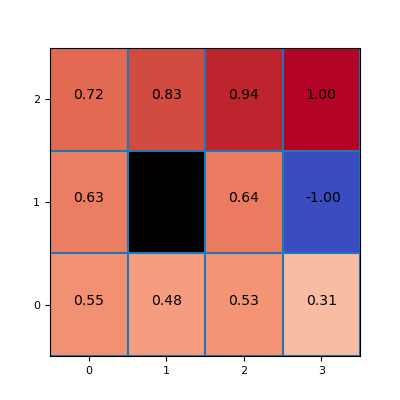

<IPython.core.display.Javascript object>


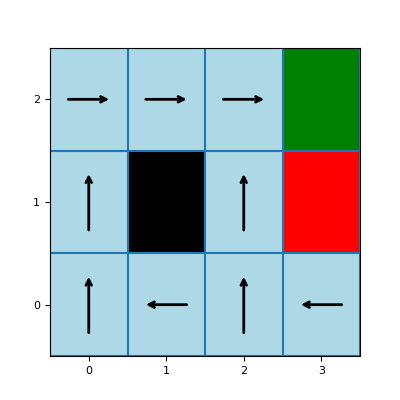

In [68]:
# Create a grid world mdp
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=0)

optimal_state_function, optimal_policy = value_iteration(grid_world, plot=True)

In [69]:
import pickle

with open('Support/data/ValueIteration_TestCase.pk', 'rb') as read_from:
    test_values = pickle.load(read_from)

test_v = test_values['value_state_function']
test_p = test_values['optimal_policy']
# print(test_v)
# print(test_p)